In [ ]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-e2l4lozq
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-e2l4lozq
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14626 sha256=1fd0722b151c80733e7b6be03ed317066649fb619f418867bd2676e7569187a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-earof84q/wheels/d7/f4/df/433336ddc98ff899ac4db5b8c4230819d9c130d002cc400cd8
Successfully built mnist1d
Cloning into 'mnist1d'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 541 (delta 67), reused 66 (delta 66), pack-reuse

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import gaussian_filter
import torch.optim as optim
import matplotlib.pylab as pl
import torch, os,time
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import mnist1d

In [ ]:
%matplotlib inline

import pylab as plt
import numpy as np


In [ ]:
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('/content/mnist1d/notebooks')
from train import get_model_args, train_model

In [ ]:
args = get_dataset_args()
data = get_dataset(args=args)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl


In [ ]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

In [ ]:
def get_mask(scores, percent_sparse):

    # Calculate the number of weights to drop
    num_to_drop = int(percent_sparse * scores.numel())

    # Get the indices of weights with the lowest scores
    ixs_to_drop = torch.argsort(scores)[:num_to_drop]  # Sort by score, select lowest `num_to_drop` scores

    # Initialize the mask with ones (retain all initially)
    mask = torch.ones_like(scores)

    # Set indices of lowest-scored weights to 0
    mask[ixs_to_drop] = 0

    return mask


In [ ]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, **kwargs):
  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

In [ ]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000
model_args.eval_every = 100
model_args.learning_rate = 2e-2


# sparsity settings
num_retrains = 100
sparsity_schedule = np.linspace(0,1.,num_retrains)

In [ ]:
num_trials = 2
trials = {'rand_models': [], 'rand_stats': [], 'lott_models': [], 'lott_stats': []}

In [ ]:
for t in range(num_trials):
  print("############  Trial {}  ############".format(t))
  print("   Random pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)

  def criteria_fn(init_params, final_params):
    mask = (final_params == 0).int()  # if params are already set to zero, keep them set to zero
    return torch.rand(final_params.shape) #* mask
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                                      criteria_fn=criteria_fn, prune_print_every=1)
  trials['rand_models'].append(models)
  trials['rand_stats'].append(stats)

  print("   Magnitude pruning")
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
  criteria_fn = lambda init_params, final_params: final_params.abs()
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                  criteria_fn=criteria_fn, prune_print_every=1)
  trials['lott_models'].append(models)
  trials['lott_stats'].append(stats)

############  Trial 0  ############
   Random pruning
	retrain #1, sparsity 0.00, final_train_loss 1.438e-01, max_acc 65.9, last_acc 64.9, mean_acc 57.9
	retrain #2, sparsity 0.01, final_train_loss 3.068e-01, max_acc 65.5, last_acc 65.1, mean_acc 58.3
	retrain #3, sparsity 0.02, final_train_loss 1.078e-01, max_acc 64.4, last_acc 64.4, mean_acc 57.4
	retrain #4, sparsity 0.03, final_train_loss 2.856e-01, max_acc 65.3, last_acc 64.9, mean_acc 58.0
	retrain #5, sparsity 0.04, final_train_loss 1.653e-01, max_acc 65.2, last_acc 63.6, mean_acc 57.5
	retrain #6, sparsity 0.05, final_train_loss 1.867e-01, max_acc 65.9, last_acc 64.8, mean_acc 57.6
	retrain #7, sparsity 0.06, final_train_loss 1.031e-01, max_acc 65.5, last_acc 64.9, mean_acc 57.9
	retrain #8, sparsity 0.07, final_train_loss 1.311e-01, max_acc 65.3, last_acc 64.9, mean_acc 58.1
	retrain #9, sparsity 0.08, final_train_loss 1.149e-01, max_acc 67.1, last_acc 67.1, mean_acc 58.3
	retrain #10, sparsity 0.09, final_train_loss 1.367e-01

In [ ]:
to_pickle(trials, path='/content/lottery.pkl')

In [ ]:
trials = from_pickle('/content/lottery.pkl')

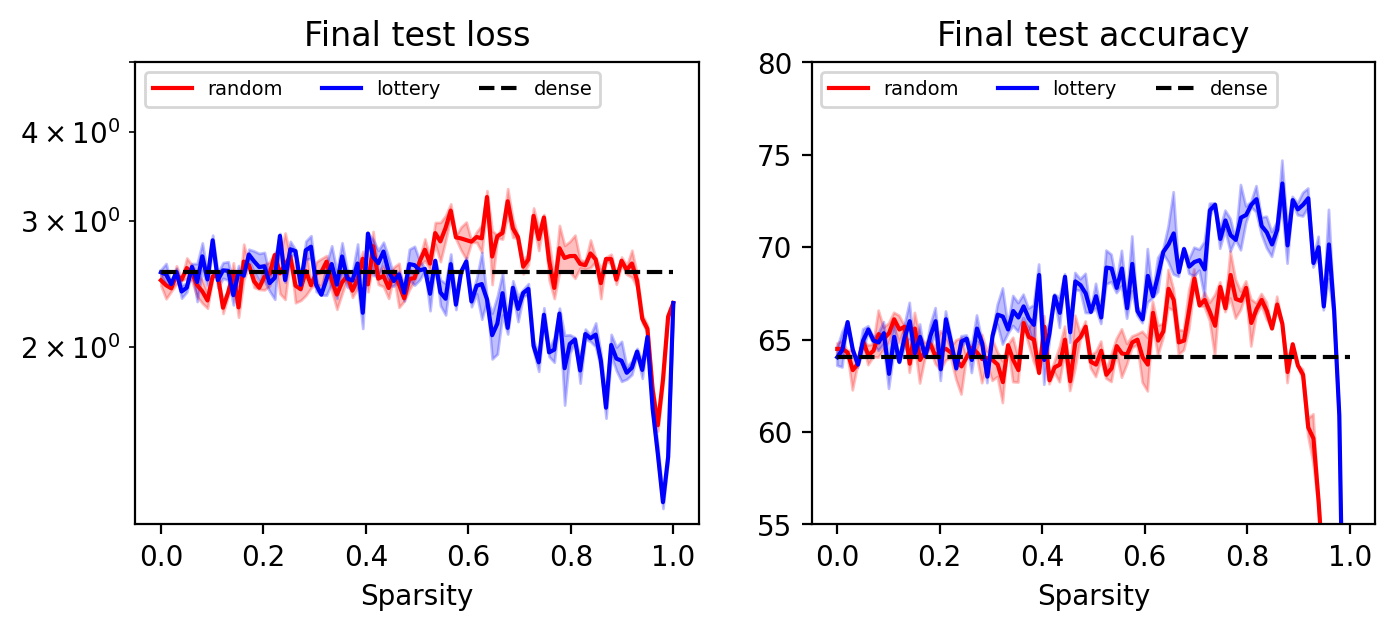

In [ ]:
def average_over(trials, trial_name, key):
    ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
    return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))
x = sparsity_schedule
# Define colors and figure
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[8, 3], dpi=200)

# Plotting Final Test Loss
plt.subplot(1, 2, 1)
for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
    y, y_err = average_over(trials, trial_name, 'test_losses')
    y, y_err = y[:, -1], y_err[:, -1]
    plt.plot(x, y, '-', color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.25)

plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity')
plt.title('Final test loss')
plt.yscale('log')
plt.ylim(None, 5e0)
plt.legend(fontsize=7, ncol=3, loc='upper left')

# Plotting Final Test Accuracy
plt.subplot(1, 2, 2)
for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
    y, y_err = average_over(trials, trial_name, 'test_accs')
    y, y_err = y[:, -1], y_err[:, -1]
    plt.plot(x, y, '-', color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.25)

plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity')
plt.title('Final test accuracy')
plt.ylim(55, 80)
plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

#  Creating new datasets from the same distribution and evaluating lottery tickets

In [ ]:
args = get_dataset_args()
args.seed = args.seed + 1  # new manual seed -> new dataset from same dataset
data = get_dataset(args=args, download=False, regenerate=True)

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10


In [ ]:
retrain_step = 91

# Model arguments configuration
model_args = get_model_args()
model_args.hidden_size = 500
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.total_steps = 6000
model_args.print_every = 1000
model_args.batch_size = 500  # Higher batch size to demonstrate overfitting

In [ ]:

# Training loop for each trial
for t in range(len(trials['rand_stats'])):
    print("\n############  Trial {}  ############".format(t))
    set_seed(model_args.seed + t)

    # Initialize models
    dense_model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
    _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
    _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

    # Prepare random and lottery ticket models
    rand_model = copy.deepcopy(dense_model)
    rand_model.set_layer_masks(_rand_model.get_layer_masks())

    lott_model = copy.deepcopy(dense_model)
    lott_model.set_layer_masks(_lott_model.get_layer_masks())

    # Train models and store results
    results['dense'].append(train_model(data, dense_model, model_args))
    results['lott'].append(train_model(data, lott_model, model_args))
    results['rand'].append(train_model(data, rand_model, model_args))

In [ ]:
results = from_pickle('/content/results.pkl')

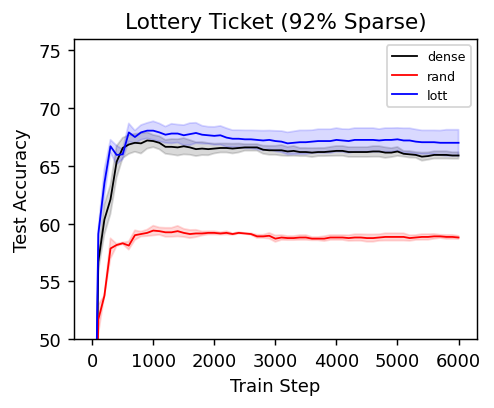

In [ ]:
def average_over_results(results, name):
    ys = [results[name][t]['test_acc'] for t in range(len(results[name]))]
    return np.mean(ys, axis=0), np.std(ys, axis=0) / np.sqrt(len(ys))

# Prepare the plot
fig = plt.figure(figsize=(4, 3), dpi=130)
x = range(0, model_args.total_steps + 1, model_args.eval_every)

# Plot results for each model type
for color, label in zip(['k', 'r', 'b'], ['dense', 'rand', 'lott']):
    y, y_err = average_over_results(results, label)
    plt.plot(x, y, color=color, label=label,linewidth = 1)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)

# Final plot settings
plt.title('Lottery Ticket ({:.0f}% Sparse)'.format(100 * sparsity_schedule[retrain_step]))
plt.ylabel('Test Accuracy')
plt.xlabel("Train Step")
plt.ylim(50, 76)
plt.legend(fontsize=7)

# Show the plot
plt.show()

In [ ]:
data_shuff = {}
np.random.seed(0)
shuffle_ixs = np.random.permutation(40) #np.array(range(32)) #
for k in data.keys():
  if k in ['x', 'x_test', 'steps']:
    data_shuff[k] = data[k][...,shuffle_ixs].copy() # shuffle sequence
  else:
    data_shuff[k] = data[k].copy()

In [ ]:
results_shuff = {'dense': [], 'lott': [], 'rand': []}

In [ ]:
for t in range(len(trials['rand_stats'])):
  print("\n############  Trial {}  ############".format(t))
  set_seed(model_args.seed + t)
  dense_model = SparseMLP(model_args.input_size, model_args.output_size, \
                          hidden_size=model_args.hidden_size)
  _rand_model = copy.deepcopy(trials['rand_models'][t][retrain_step])
  _lott_model = copy.deepcopy(trials['lott_models'][t][retrain_step])

  rand_model = copy.deepcopy(dense_model)
  rand_model.set_layer_masks(_rand_model.get_layer_masks())

  lott_model = copy.deepcopy(dense_model)
  lott_model.set_layer_masks(_lott_model.get_layer_masks())

  dense = train_model(data_shuff, dense_model, model_args) ; results_shuff['dense'].append(dense)
  lott = train_model(data_shuff, lott_model, model_args)   ; results_shuff['lott'].append(lott)
  rand = train_model(data_shuff, rand_model, model_args)   ; results_shuff['rand'].append(rand)

In [ ]:
to_pickle(results_shuff, path='/content/results_shuff.pkl')

In [ ]:
results_shuff = from_pickle('/content/results_shuff.pkl')

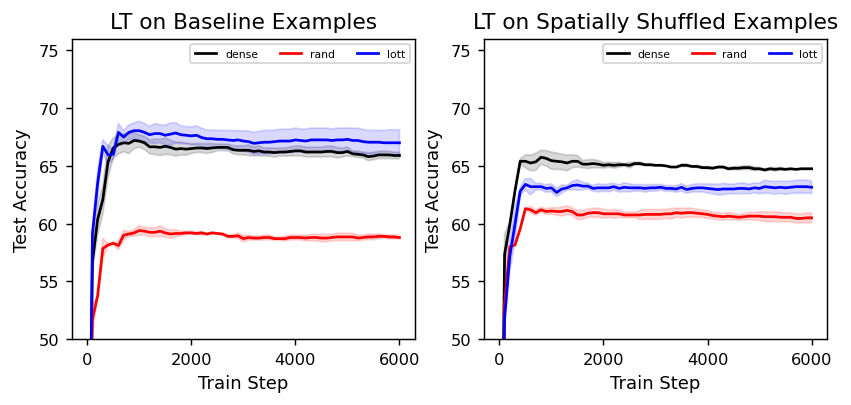

In [ ]:
import matplotlib.pyplot as plt

# Prepare the figure
fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps + 1, model_args.eval_every)

# Plot for baseline examples
plt.subplot(1, 2, 1)
plt.title('LT on Baseline Examples')
for color, label in zip(['k', 'r', 'b'], ['dense', 'rand', 'lott']):
    y, y_err = average_over_results(results, label)
    plt.plot(x, y, color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)

plt.ylim(50, 76)
plt.ylabel('Test Accuracy')
plt.xlabel("Train Step")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(fontsize=6, ncol=3)

# Plot for spatially shuffled examples
plt.subplot(1, 2, 2)
plt.title('LT on Spatially Shuffled Examples')
for color, label in zip(['k', 'r', 'b'], ['dense', 'rand', 'lott']):
    y, y_err = average_over_results(results_shuff, label)
    plt.plot(x, y, color=color, label=label)
    plt.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)

plt.ylim(50, 76)
plt.ylabel('Test Accuracy')
plt.xlabel("Train Step")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(fontsize=6, ncol=3)

# Show the plot
plt.show()

# What if we flip the dataset

In [ ]:
data_flip = {}
for k in data.keys():
  if k in ['x', 'x_test', 'steps']:
    data_flip[k] = data[k][...,::-1].copy()
  else:
    data_flip[k] = data[k].copy()

In [ ]:
results_flip = {'dense': [], 'lott': [], 'rand': []}


In [ ]:
for t in range(len(trials['rand_stats'])):
    print("\n############  Trial {}  ############".format(t))
    set_seed(model_args.seed + t)
    dense_model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
    rand_model = copy.deepcopy(dense_model)
    rand_model.set_layer_masks(trials['rand_models'][t][retrain_step].get_layer_masks())

    lott_model = copy.deepcopy(dense_model)
    lott_model.set_layer_masks(trials['lott_models'][t][retrain_step].get_layer_masks())
    results_flip['dense'].append(train_model(data_flip, dense_model, model_args))
    results_flip['lott'].append(train_model(data_flip, lott_model, model_args))
    results_flip['rand'].append(train_model(data_flip, rand_model, model_args))

In [ ]:
to_pickle(results_shuff, path='/content/results_flip.pkl')

In [ ]:
results_flip = from_pickle('/content/results_flip.pkl')

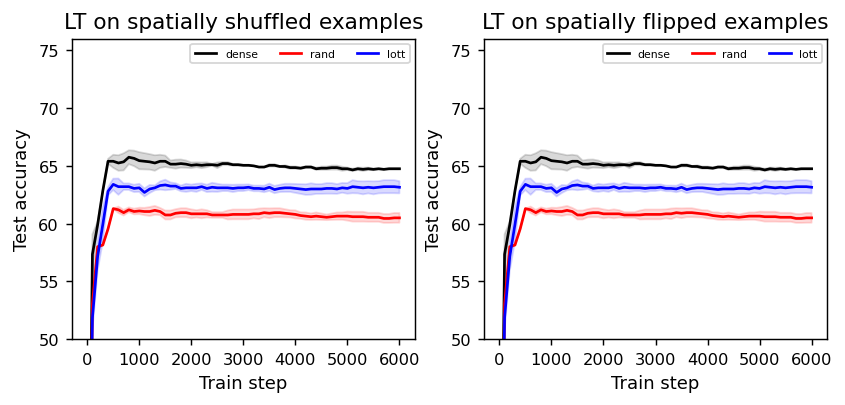

In [ ]:
def plot_results(ax, title, results, x):
    ax.set_title(title)
    for label, color in zip(['dense', 'rand', 'lott'], ['k', 'r', 'b']):
        y, y_err = average_over_results(results, label)
        ax.plot(x, y, color=color, label=label)
        ax.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)
    ax.set_ylim(50, 76)
    ax.set_ylabel('Test accuracy')
    ax.set_xlabel("Train step")
    ax.tick_params(axis='both', labelsize=9)
    ax.legend(fontsize=6, ncol=3)

fig = plt.figure(figsize=(7.5, 3), dpi=130)
x = range(0, model_args.total_steps + 1, model_args.eval_every)

# Plot for spatially shuffled examples
ax1 = plt.subplot(1, 2, 1)
plot_results(ax1, 'LT on spatially shuffled examples', results_shuff, x)

# Plot for spatially flipped examples
ax2 = plt.subplot(1, 2, 2)
plot_results(ax2, 'LT on spatially flipped examples', results_flip, x)

plt.show()

# Ablation


# Assessing the Robustness of Lottery Tickets: An Ablation Study with Noise Injection, Label Permutation, and Input Cropping on MNIST1D

In [ ]:
def inject_noise(data, noise_level=0.1):
    data_noisy = {}
    for k in ['x', 'x_test']:
        noise = np.random.normal(0, noise_level, data[k].shape)
        data_noisy[k] = data[k] + noise
    for k in ['y', 'y_test']:
        data_noisy[k] = data[k]
    return data_noisy

def permute_labels(data):
    data_perm = {}
    perm = np.random.permutation(len(data['y']))
    for k in ['x', 'x_test']:
        data_perm[k] = data[k]
    data_perm['y'] = data['y'][perm]
    data_perm['y_test'] = data['y_test']
    return data_perm

def crop_input(data, crop_length=10):
    data_cropped = {}
    for k in ['x', 'x_test']:
        cropped = data[k].copy()
        for i in range(cropped.shape[0]):
            start = np.random.randint(0, cropped.shape[-1] - crop_length + 1)
            cropped[i, start:start + crop_length] = 0
        data_cropped[k] = cropped
    for k in ['y', 'y_test']:
        data_cropped[k] = data[k]
    return data_cropped




1.   **Noise Injection**: Tests the robustness of the model to small variations in inputs.
2.   **Label Permutation**: Evaluates how much the model relies on meaningful input-label mapping.
3.   **Input Cropping**: Analyzes the ability of the model to learn when parts of the sequence are removed.



In [ ]:
perturbations = {
    'noise_injection': lambda data: inject_noise(data, noise_level=0.2),
    'label_permutation': permute_labels,
    'input_cropping': lambda data: crop_input(data, crop_length=10),
}

results_perturb = {}

for perturb_name, perturb_fn in perturbations.items():
    print(f"\n#### Perturbation: {perturb_name} ####")
    data_perturb = perturb_fn(data)
    results_perturb[perturb_name] = {'dense': [], 'lott': [], 'rand': []}

    for t in range(len(trials['rand_stats'])):
        print(f"\nTrial {t} with {perturb_name}")
        set_seed(model_args.seed + t)

        # Initialize models
        dense_model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
        rand_model = copy.deepcopy(dense_model)
        rand_model.set_layer_masks(trials['rand_models'][t][retrain_step].get_layer_masks())
        lott_model = copy.deepcopy(dense_model)
        lott_model.set_layer_masks(trials['lott_models'][t][retrain_step].get_layer_masks())

        # Train models
        results_perturb[perturb_name]['dense'].append(train_model(data_perturb, dense_model, model_args))
        results_perturb[perturb_name]['rand'].append(train_model(data_perturb, rand_model, model_args))
        results_perturb[perturb_name]['lott'].append(train_model(data_perturb, lott_model, model_args))



#### Perturbation: noise_injection ####

Trial 0 with noise_injection
step 1000, dt 26.16s, train_loss 1.284e-03, test_loss 2.274e+00, train_acc 100.0, test_acc 59.6
step 2000, dt 28.66s, train_loss 3.413e-04, test_loss 2.607e+00, train_acc 100.0, test_acc 59.2
step 3000, dt 29.43s, train_loss 1.405e-04, test_loss 2.843e+00, train_acc 100.0, test_acc 59.5
step 4000, dt 28.55s, train_loss 6.735e-05, test_loss 3.042e+00, train_acc 100.0, test_acc 59.1
step 5000, dt 29.47s, train_loss 3.513e-05, test_loss 3.223e+00, train_acc 100.0, test_acc 58.6
step 6000, dt 29.30s, train_loss 1.905e-05, test_loss 3.394e+00, train_acc 100.0, test_acc 58.5
step 1000, dt 27.63s, train_loss 4.430e-03, test_loss 3.119e+00, train_acc 100.0, test_acc 54.0
step 2000, dt 34.33s, train_loss 8.163e-04, test_loss 3.849e+00, train_acc 100.0, test_acc 54.7
step 3000, dt 37.51s, train_loss 2.886e-04, test_loss 4.302e+00, train_acc 100.0, test_acc 54.7
step 4000, dt 39.70s, train_loss 1.277e-04, test_loss 4.663e+00, 

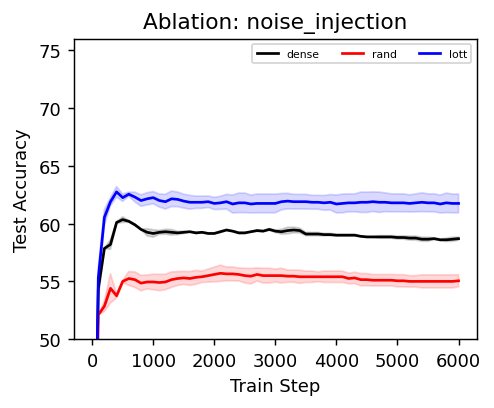

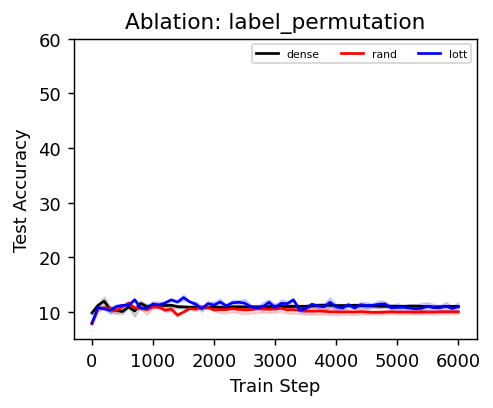

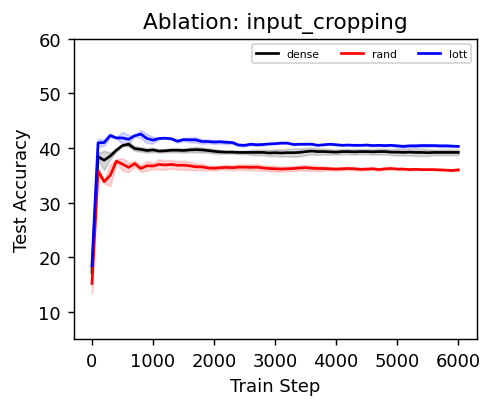

In [ ]:
def plot_perturbation_results(results_perturb, perturb_name, x):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=130)

    for color, label in zip(['k', 'r', 'b'], ['dense', 'rand', 'lott']):
        y, y_err = average_over_results(results_perturb[perturb_name], label)
        ax.plot(x, y, color=color, label=label)
        ax.fill_between(x, y - y_err, y + y_err, color=color, alpha=0.15)

    # Set different y-limits for "label permutation" and "cropping"
    if perturb_name == "label_permutation" or perturb_name == "input_cropping":
        ax.set_ylim(5, 60)
    else:
        ax.set_ylim(50, 76)

    ax.set_title(f'Ablation: {perturb_name}')
    ax.set_ylabel('Test Accuracy')
    ax.set_xlabel("Train Step")
    ax.legend(fontsize=6, ncol=3)
    plt.show()

# Plot results for each perturbation
for perturb_name in perturbations.keys():
    plot_perturbation_results(results_perturb, perturb_name, x)
